<a href="https://colab.research.google.com/github/valentingorce/tp_centrale/blob/main/Day2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Information Retrieval
## Introduction to search engines

### DAY 2: Teacher version
### Implementing a search engine

The goal of this second session is to implement a first architecture of a search engine on the previously introduced dataset (stackexchange-datascience). If you missed the first session or if you did not saved the dataset, please reload the first session's notebook to download it. 

If you need some ifnormation about the dataset, it should be available here : https://archive.org/details/stackexchange

The notebook is divided into several steps:
-	Implement the indexation
-	Implement the search method
-	Define a ranking strategy and implement it
-	Suggest some improvements of the search engine



## Initialisation

In [55]:
!pip install ttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [59]:
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#from tt import BooleanExpression
from itertools import product
import numpy as np
import transformers
from textblob import TextBlob
from textblob import Word
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
# Only if you use Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# TODO:
DATA_PATH = 'drive/MyDrive/EI_web_data/Data' 


**Important :**

An Excel file for testing the evaluation part is available in the gitlab repo : evaluation_search_engine_post_queries_ranking_EI_CS.xlsx

If you work on Colab, we advice you to push it directly on your Google Drive directory.

# Implement the indexation
As you might already know, for a search engine to work properly an index of the documents must be created. Here we will keep it in python, and try to use only common libraries to keep it simple.

Once created, the index will be used to match the query with the documents. As a result, there are several ways to build an index, using statistical, boolean, semantic indexation...

First of, let's make a naive one that will consist in breaking down each document into a set of the words it contains.

In [64]:
def extract_words(text:str)->list:
  tokenizer=transformers.AutoTokenizer.from_pretrained("bert-base-uncased")
  tokens= tokenizer.tokenize(text)

  return tokens

In [65]:
def extract_words_textblob(text:str)->list:
  tokens=[]
  for tuple in TextBlob(text).tags : #pour chaque mot
      mot_en_minuscule=tuple[0].lower() #on le met en minuscule

      #on retire le "."
      if mot_en_minuscule[-1]==".":
        mot_en_minuscule=mot_en_minuscule[:-1]

      if mot_en_minuscule not in stopwords.words('english'):
        tokens.append(Word(mot_en_minuscule).lemmatize()) #on transforme en mot un Word puis on lemmatise
  return tokens



In [66]:
# test
s = "The cat is sat on the mat. The dog is laid on the mat."
print (extract_words_textblob(s))

['cat', 'sat', 'mat', 'dog', 'laid', 'mat']


As you may notice, there are several problems with the previous implementation. First, "The" and "the" aren't considered the same, the "." is kept at the the end of "mat." as any other punctuation character... 

Re-implement this function with some basic preprocessing to avoid these issues.

Now you sould be able to create your index table. For now we will just make a dataframe with two columns: [raw_text, words].

In [67]:
import pandas as pd

def index_docs(docs:list[str])->pd.DataFrame:
  return pd.DataFrame([[doc, extract_words(doc)]for doc in docs])

In [68]:
# test

L = [s, "Hello World!", "Goodbye", "How are you?"]

index_docs(L)

,0,1
0,The cat is sat on the mat. The dog is laid on ...,"[the, cat, is, sat, on, the, mat, ., the, dog,..."
1,Hello World!,"[hello, world, !]"
2,Goodbye,[goodbye]
3,How are you?,"[how, are, you, ?]"


Now, let's try it on the dataset:

In [69]:
posts = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")
posts

,Id,PostTypeId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,...,ClosedDate,ContentLicense,AcceptedAnswerId,LastEditorUserId,LastEditDate,ParentId,OwnerDisplayName,CommunityOwnedDate,LastEditorDisplayName,FavoriteCount
0,5,1,2014-05-13T23:58:30.457,9,898.0,<p>I've always been interested in machine lear...,5.0,2014-05-14T00:36:31.077,How can I do simple machine learning without h...,<machine-learning>,...,2014-05-14T14:40:25.950,CC BY-SA 3.0,NaN,NaN,None,NaN,None,None,None,NaN
1,7,1,2014-05-14T00:11:06.457,4,478.0,"<p>As a researcher and instructor, I'm looking...",36.0,2014-05-16T13:45:00.237,What open-source books (or other materials) pr...,<education><open-source>,...,2014-05-14T08:40:54.950,CC BY-SA 3.0,10.0,97.0,2014-05-16T13:45:00.237,NaN,None,None,None,NaN
2,9,2,2014-05-14T00:36:31.077,5,NaN,"<p>Not sure if this fits the scope of this SE,...",51.0,2014-05-14T00:36:31.077,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,5.0,None,None,None,NaN
3,10,2,2014-05-14T00:53:43.273,13,NaN,"<p>One book that's freely available is ""The El...",22.0,2014-05-14T00:53:43.273,None,None,...,None,CC BY-SA 3.0,NaN,NaN,None,7.0,None,None,None,NaN
4,14,1,2014-05-14T01:25:59.677,26,1901.0,<p>I am sure data science as will be discussed...,66.0,2020-08-16T13:01:33.543,Is Data Science the Same as Data Mining?,<data-mining><definitions>,...,None,CC BY-SA 3.0,29.0,322.0,2014-06-17T16:17:20.473,NaN,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75722,119962,1,2023-03-04T20:06:06.820,0,8.0,<p>I am implementing a neural network of arbit...,147597.0,2023-03-04T20:22:12.523,Back Propagation on arbitrary depth network wi...,<neural-network><backpropagation>,...,None,CC BY-SA 4.0,NaN,147597.0,2023-03-04T20:22:12.523,NaN,None,None,None,NaN
75723,119963,1,2023-03-04T20:12:19.677,0,10.0,<p>I am using KNN for a regression task</p>\n<...,147598.0,2023-03-04T20:12:19.677,Evaluation parameter in knn,<regression><k-nn>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN
75724,119964,1,2023-03-05T00:14:12.597,0,7.0,<p>I have developed a small encoding algorithm...,44581.0,2023-03-05T00:14:12.597,Can I use zero-padded input and output layers ...,<deep-learning><convolutional-neural-network>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN
75725,119965,1,2023-03-05T00:43:12.213,0,5.0,"<p>To my understanding, optimizing a model wit...",84437.0,2023-03-05T00:43:12.213,Why does cross validation and hyperparameter t...,<cross-validation><hyperparameter-tuning>,...,None,CC BY-SA 4.0,NaN,NaN,None,NaN,None,None,None,NaN


For our first version of the indexation mechanism, we will simply use the "body" of the posts. To have a better search engine, the title and other metadata aswell could be used aswell. Finally, not all the XML files have a "body" feature, so for the search engine to retrieve information from any of the files you will need to implement another way to index.

But first, let's start with "body". There is more to preprocess than before, indeed, there are html tags such as "<p>" for instance. They are not useful for us, because users won't use them in their queries. So we first need to remove them.

In [70]:
def remove_tags(text:str)->str:
  soup = BeautifulSoup(text, 'html.parser')

  # Supprimer toutes les balises de script et de style
  for script in soup(['script', 'style']):
    script.extract()

  # Obtenir le texte propre sans balises
  texte_propre = soup.get_text()
  
  # Supprimer les espaces supplémentaires et les sauts de ligne
  texte_propre = re.sub(r'\s+', ' ', texte_propre)

  return texte_propre

In [71]:
# test
remove_tags('<p>Hello World!\nI am making a search engine.<p>')

'Hello World! I am making a search engine.'

In [72]:
clean_posts = posts[['Id','Body']]
clean_posts['Clean_Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
clean_posts

<ipython-input-70-91ecd1cbc6de>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')
<ipython-input-72-12e2ea0be408>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean_Body'] = clean_posts['Body'].fillna('').apply(remove_tags)


,Id,Body,Clean_Body
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...
...,...,...,...
75722,119962,<p>I am implementing a neural network of arbit...,I am implementing a neural network of arbitrar...
75723,119963,<p>I am using KNN for a regression task</p>\n<...,I am using KNN for a regression task It's like...
75724,119964,<p>I have developed a small encoding algorithm...,I have developed a small encoding algorithm th...
75725,119965,"<p>To my understanding, optimizing a model wit...","To my understanding, optimizing a model with k..."


In [73]:
#clean_posts['words'] = clean_posts['Clean_Body'].apply(extract_words_textblob)
clean_posts

,Id,Body,Clean_Body
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...
...,...,...,...
75722,119962,<p>I am implementing a neural network of arbit...,I am implementing a neural network of arbitrar...
75723,119963,<p>I am using KNN for a regression task</p>\n<...,I am using KNN for a regression task It's like...
75724,119964,<p>I have developed a small encoding algorithm...,I have developed a small encoding algorithm th...
75725,119965,"<p>To my understanding, optimizing a model wit...","To my understanding, optimizing a model with k..."


## Inverted Index

Now, we want to go further on the indexing and build an inverted index. Inverted index is a dictionary where the keys are the words of the vocabulary and the values are the documents containing these words. Reducing the size of the vocabulary is a relevant first step when building an inverted index. Here, we will focus on the creation of the index, we leave you the optimisation steps :)

In [74]:
def clean_df(posts):
  clean_posts = posts[['Id','Body']]
  clean_posts['Clean_Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
  clean_posts['words'] = clean_posts['Clean_Body'].apply(extract_words_textblob)
  return clean_posts

In [75]:
def create_index(clean_posts:pd.DataFrame)-> set:
  ''' renvoie un dictionnaire de la forme 
  dic={mot:{id:f_id}}
  '''

  dic={}
  for rang in clean_posts.index:
    words=clean_posts.loc[rang, 'words']
    id=clean_posts.loc[rang,'Id']
    for word in words:
      if word in dic.keys(): #si le mot est déjà apparu dans le corpus
        if id in dic[word].keys(): #si le mot est déjà apparu dans ce document
          dic[word][id]+=1
        else:
          dic[word][id]=1 #première occurence du mot dans ce document
      else:#première occurence du mot dans le corpus
        dic[word]={id: 1}

  return dic

In [76]:
#clean_posts['Id']['Words'] #clean_posts trop long

In [77]:
#test sur un dataframe plus petite
test_posts=posts.sample(n=20)
clean_test_posts=clean_df(test_posts)


<ipython-input-74-ace5277ed51f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean_Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
<ipython-input-74-ace5277ed51f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['words'] = clean_posts['Clean_Body'].apply(extract_words_textblob)


In [78]:
inverted_index = create_index(clean_test_posts)

#### Well Done, you've indexed the dataset! 
Don't hesitate to save your indexes in txt or pickle file

## Zipf Law

A way of analyzing a corpus is to draw the zipf law

In [79]:
# TODO : Draw Zipf Law on the Posts Corpus
def get_sorted_index(posts:pd.DataFrame)-> set:
  inverted_index = create_index(clean_df(posts))
  L=[]
  for word in inverted_index:
    total_occurence=sum(f for f in inverted_index[word].values())
    L.append((word,total_occurence))

  return sorted(L, key=lambda x: x[-1], reverse=True)
  

<ipython-input-74-ace5277ed51f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean_Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
<ipython-input-74-ace5277ed51f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['words'] = clean_posts['Clean_Body'].apply(extract_words_textblob)


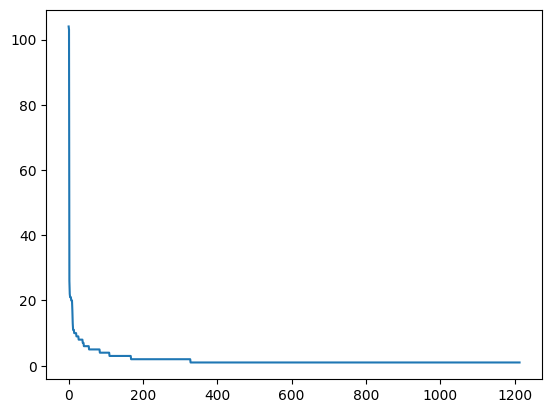

In [80]:
L=get_sorted_index(test_posts)
plt.plot( [e[-1]for e in L])

---
# Implement the search method

A naive method would be to count the number of words in common between the query and each posts. Then to rank the posts you could directly select the post who maximize the number of common words. Let's implement this approach :

In [81]:
# Implement the word_in_index function 

def word_in_index(word, word_list_index):
  '''Create a Boolean Series indicating if each word in the list matches the given word
  Inputs : a word (str) & a list of words
  Output : pandas series of 1 if the word is in the list, else 0'''
  series = pd.Series([1 if w == word else 0 for w in word_list_index])
  return series


In [82]:
# Implement the function which run through a pandas series and count the number of word in common
# Use extract_words method, apply method with word_in_index function
# Inputs : the query (str) & pandas series of strings
# Output : Pandas series counting the number of common words between the query and each string in word_serie

def count_common_words(query, word_serie):
  query_words=extract_words_textblob(query)
  return sum(word_in_index(word, word_serie)for word in query_words)

In [83]:
def rank_top_query(query, df, top=5):
  query_df=df.copy()
  query_df['common']=query_df['words'].apply(lambda word_list : sum(count_common_words(query, word_list)))
  return query_df.nlargest(top, 'common')

In [84]:
clean_test_posts=clean_df(posts.sample(100))

<ipython-input-74-ace5277ed51f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean_Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
<ipython-input-74-ace5277ed51f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['words'] = clean_posts['Clean_Body'].apply(extract_words_textblob)


In [85]:
rank_top_query(query="testing the query in python", df=clean_test_posts, top=5)

,Id,Body,Clean_Body,words,common
67223,109166,<p>I have a background in GIS and am just lear...,I have a background in GIS and am just learnin...,"[background, gi, learning, data, science, usin...",3
19733,31043,<p>There might not be an entire book about uns...,There might not be an entire book about unsupe...,"[might, entire, book, unsupervised, technique,...",3
10527,17313,<p>If you are using a scraping tool that manag...,If you are using a scraping tool that manages ...,"[using, scraping, tool, manages, web, session,...",2
58298,92342,<p>I am working on raw text data. I am using c...,I am working on raw text data. I am using clus...,"[working, raw, text, data, using, clustering, ...",1
16485,26723,<p>Developing a application where sometimes wh...,Developing a application where sometimes when ...,"[developing, application, sometimes, make, que...",1


Testez plusieurs requêtes et critiquez les résultats obtenus.

Quels sont les pros and cons de cette méthodes. Vous l'indiquerez sur le rapport avec vos réflexions pour l'améliorer.

Next, you have to implement the first improvements you find in the search method to get most relevant results 

In [86]:

def remove_stop_words(l_txt: list) -> list:
  # TODO
  #déjà fait au début

  return 

## Boolean Search

Thanks to the ttable library, implement a boolean search method

In [87]:
def boolean_search(query):
  # TODO

  return

## Probabilistic search

Implement the MIB or BM25 method of searching

In [88]:
def IDF(terme,df):
  inverted_index=create_index(df)
  n=len(inverted_index[terme])# nombre de documents contenants le terme
  N=len(df) #nombre de docs dans la collection
  return math.log((N-n+0.5)/(n+0.5))

In [89]:
test_posts=posts.sample(n=50)

In [90]:
def BM25(query, posts, k1=1.5, b=0.75, top=5):
  processed_query=extract_words_textblob(query)
  clean_posts=clean_df(posts)
  inverted_index=create_index(clean_posts)
  N=len(clean_posts) #nombre de docs dans la collection
  clean_posts['lenght']=clean_posts['words'].apply(lambda x : len(x))#longueur du doc
  avgdl=clean_posts['lenght'].mean()#longueur moyenne des docs

  scores=[]
  for rang in clean_posts.index:
    doc_id=clean_posts.loc[rang,'Id']
    lenght=clean_posts.loc[rang,'lenght']
    
    #calcul du score du document
    s=0
    for terme in processed_query:
      
      if terme not in inverted_index : 
        s+=0 #le terme n'apparait ni dans le doc ni même dans le corpus --> contribution nulle au score 
      else :
        n=len(inverted_index[terme]) # nombre de documents contenants le terme
        
        IDF=math.log((N-n+0.5)/(n+0.5))
        if doc_id in inverted_index[terme]: freq=inverted_index[terme][doc_id]
        else: freq=0
        s+=IDF*freq*(k1+1)/(freq+k1*(1-b+b*lenght/avgdl))
    
    scores.append(s)

  #ajout d'une colonne 'score' à la dataframe clean_posts
  clean_posts['score']=scores

  return clean_posts.nlargest(top, 'score')

In [91]:
test_posts=posts.sample(n=200)

In [96]:
query='what is stochastic gradient descent ?'
BM25(query, test_posts).Clean_Body.values

<ipython-input-74-ace5277ed51f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean_Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
<ipython-input-74-ace5277ed51f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['words'] = clean_posts['Clean_Body'].apply(extract_words_textblob)
<ipython-input-90-24cef9d387f9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

array(["There are at least two uncomplicated ways to deal with this issue. If your data has a lot of zeros etc. it might be worth trying to load it as a sparse dataframe. One thing that always works is to process your data in an iterative fashion. For most datatypes pandas can let you iterate through your file, e.g. with pandas.read_csv(data, iterator=True). This is not available for JSON data, but you can use the ijson package instead. Many scikit-learn algorithms can also be trained iteratively on one or a few samples (mini-batches) at a time. In particular, the flexible linear models with stochastic gradient descent (SGDClassifier and SGDRegressor). For clustering, you can use MiniBatchKMeans. You can read more about this in the documentation. If your data fits almost into memory, you may just read in as much as possible. If most of it doesn't fit, there is probably no way that lets you use pandas/sklearn without some adjustments. ",
       'I am attempting to implement a basic Stoc

Compare the naive method with your improvements and the boolean and probabilistic search. (report)



---



---




# Evaluate the Search

Now you implement multiple search methods and you're able to improve it. You have to define metric to compare it objectively.



We ask you to implement NDCG (Normalized Discounted Cumulative Gain) from few queries we implement on a dozen of post. We already defined the values of relevance judgement in the xlsx file : . The final score will be the mean quadratic error of the queries.


Explication for the xlsx file :

We propose you a Excel file with some posts and a mesure of relevancy for the queries

- First column is the post Id,
- Columns starting by query are the queries you have to test.
- The values in this columns are the rank of relevancy of the post in regard with the query.
- The missing values indicates you should not take into account the post


You will have to criticize this metric and your result in the report. Then you will have to propose some improvements. 

Thereafter in this week, you will have to compare your different search engines.

In [ ]:
# Read Relevancy CSV
df_relevancy = pd.read_excel("/content/drive/MyDrive/TP Centrale/evaluation_search_engine_post_queries_ranking_EI_CS.xlsx")

In [ ]:
def calculate_ndgc(query_col="query", output_col="query_output"):
  # TODO

  return

